In [23]:
from pandas import DataFrame, Series, read_csv
from numpy import ndarray, log
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots, figure, tight_layout
from scipy.stats import norm, expon, lognorm
from dslabs_functions import get_variable_types, define_grid, plot_multibar_chart, set_chart_labels, plot_multiline_chart, plot_bar_chart, HEIGHT


In [13]:
file_tag = "class_pos_covid_distribution"
data: DataFrame = read_csv("datasets/class_pos_covid.csv", index_col=None, na_values="")
summary5: DataFrame = data.describe(include="all")
summary5

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
count,380932,380932,379975,371944.000000,373512.000000,374139,380127,376556.000000,371702,378555,...,372301.000000,360571.000000,355324.000000,376031,362611,378227,351134,346245,379456,380932
unique,54,2,5,NaN,NaN,4,2,NaN,4,2,...,NaN,NaN,NaN,2,2,2,2,4,2,2
top,Washington,Female,Very good,NaN,NaN,Within past year (anytime less than 12 months ...,Yes,NaN,None of them,No,...,NaN,NaN,NaN,Yes,No,Yes,No,"No, did not receive any tetanus shot in the pa...",No,No
freq,22388,201499,127352,NaN,NaN,301086,288481,NaN,198338,356585,...,NaN,NaN,NaN,196484,239602,198580,204991,116598,362957,270055
mean,NaN,NaN,NaN,4.384991,4.415732,NaN,NaN,7.022823,NaN,NaN,...,1.702571,83.217059,28.586092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,8.742091,8.404087,NaN,NaN,1.491101,NaN,NaN,...,0.107171,21.485738,6.571412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,1.000000,NaN,NaN,...,0.910000,22.680000,12.020000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,6.000000,NaN,NaN,...,1.630000,68.040000,24.140000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,7.000000,NaN,NaN,...,1.700000,81.190000,27.440000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,3.000000,5.000000,NaN,NaN,8.000000,NaN,NaN,...,1.780000,95.250000,31.840000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


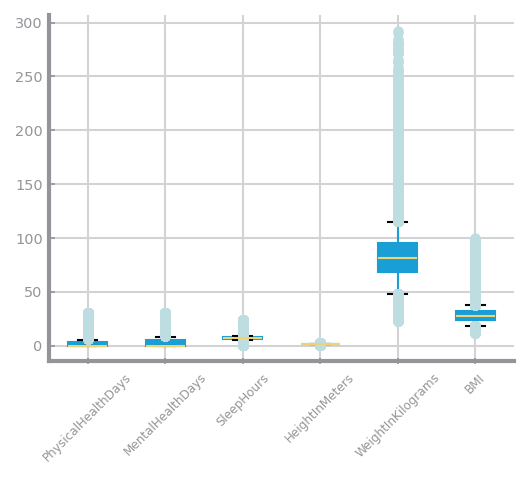

In [14]:
variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]
if [] != numeric:
    data[numeric].boxplot(rot=45)
    savefig(f"images/{file_tag}_global_boxplot.png", bbox_inches="tight")
    show()
else:
    print("There are no numeric variables.")

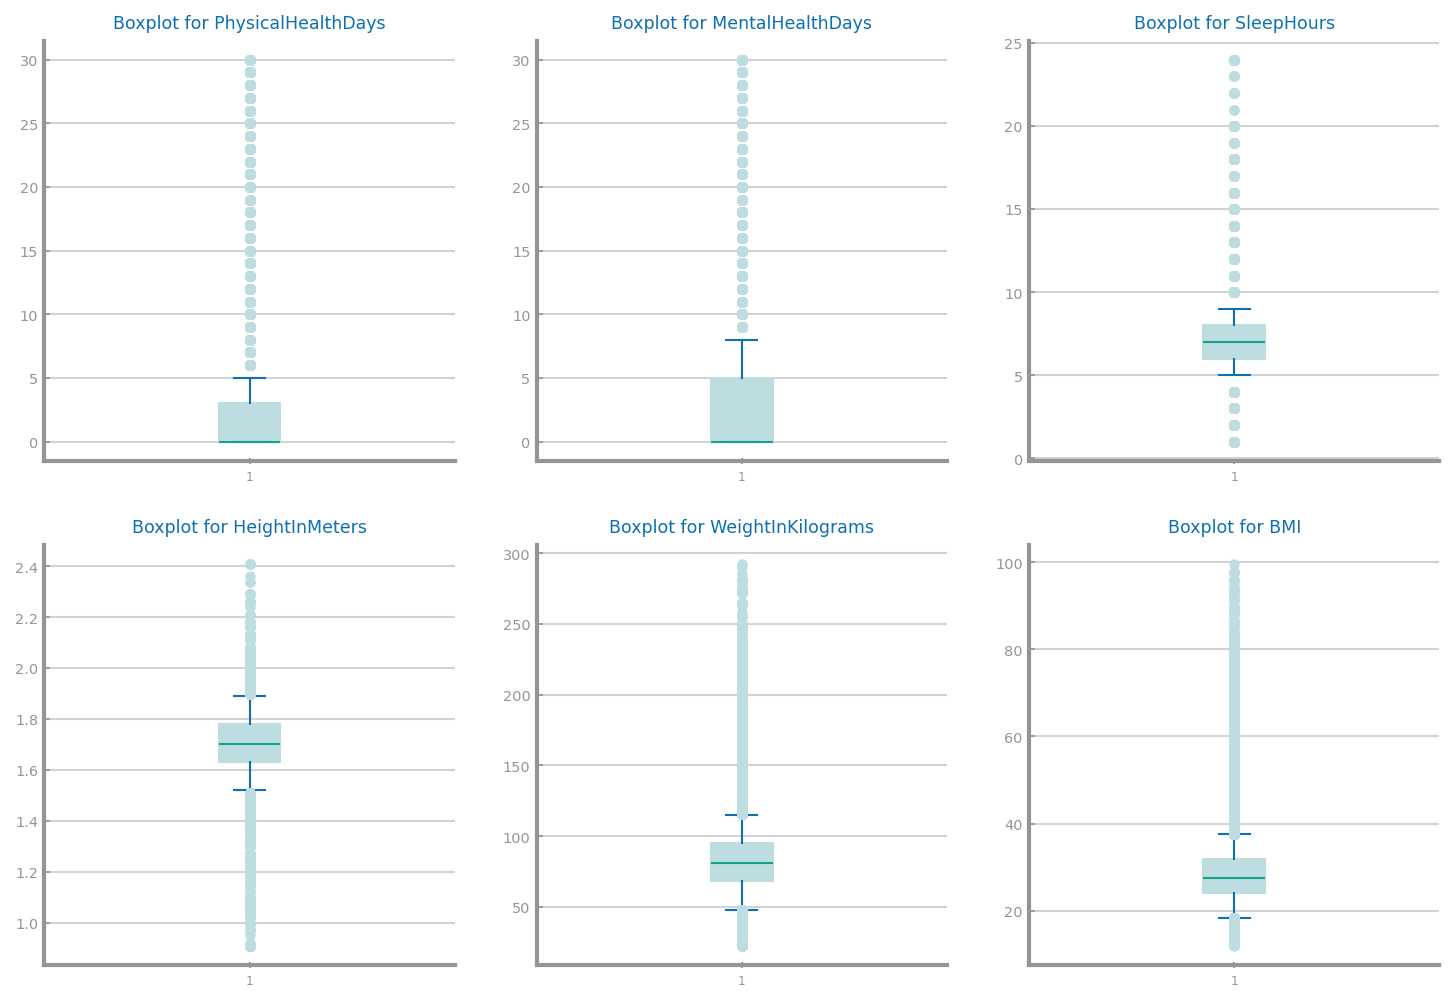

In [15]:
if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(data[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png", bbox_inches="tight")
    show()
else:
    print("There are no numeric variables.")

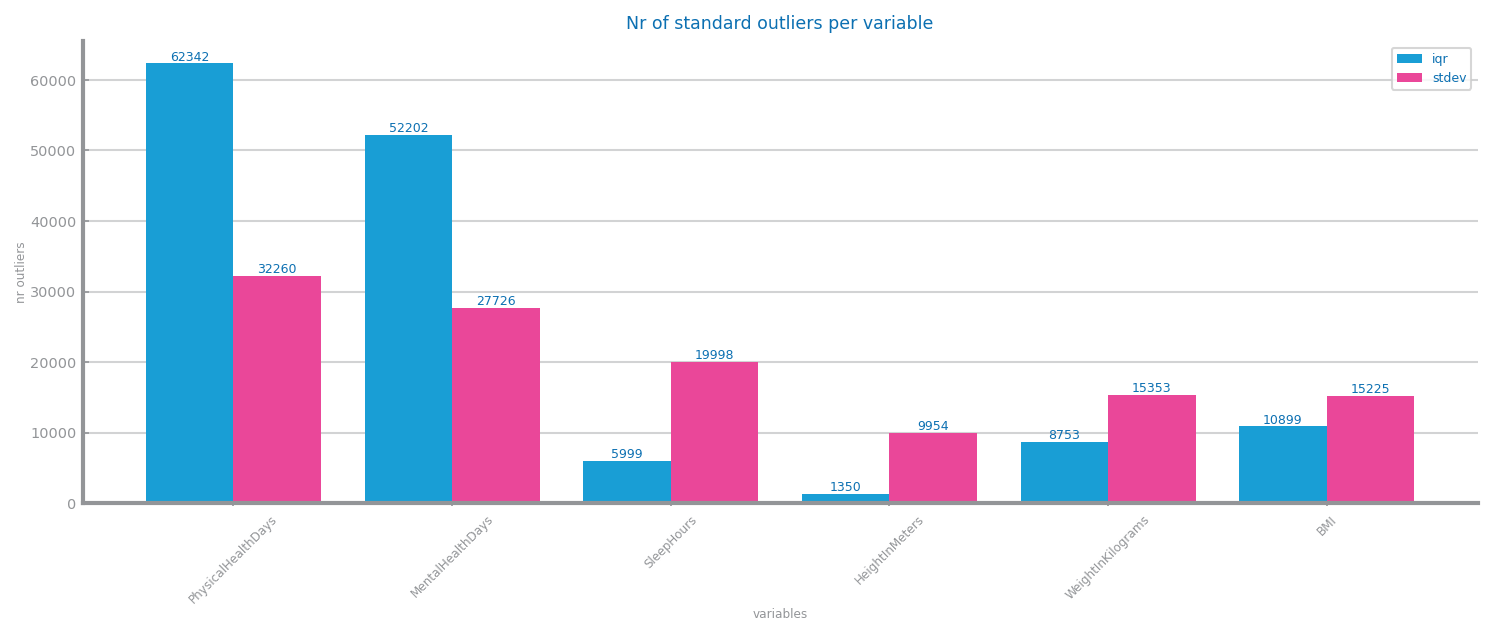

In [16]:
NR_STDEV: int = 2
IQR_FACTOR: float = 1.5


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}


if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title="Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers_standard.png", bbox_inches="tight")
    show()
else:
    print("There are no numeric variables.")

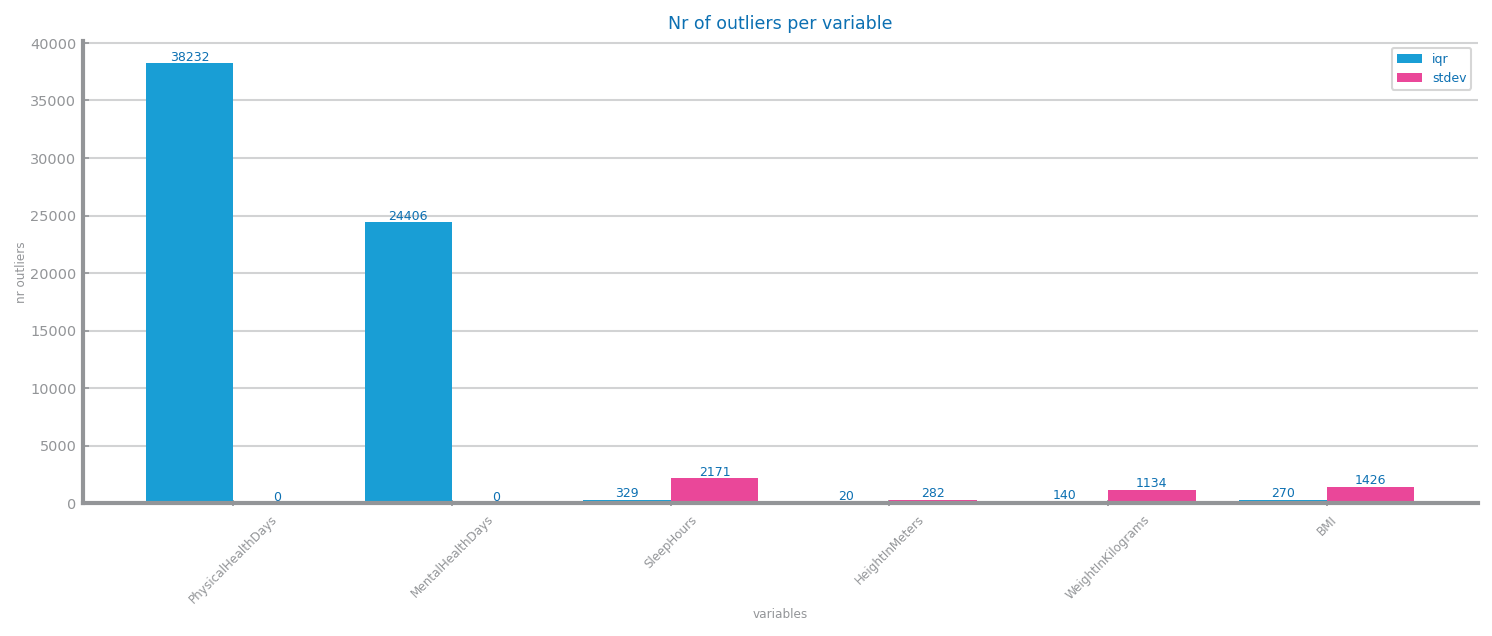

In [17]:
if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric, nrstdev=4, iqrfactor=4.5)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title="Nr of outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers.png", bbox_inches="tight")
    show()
else:
    print("There are no numeric variables.")

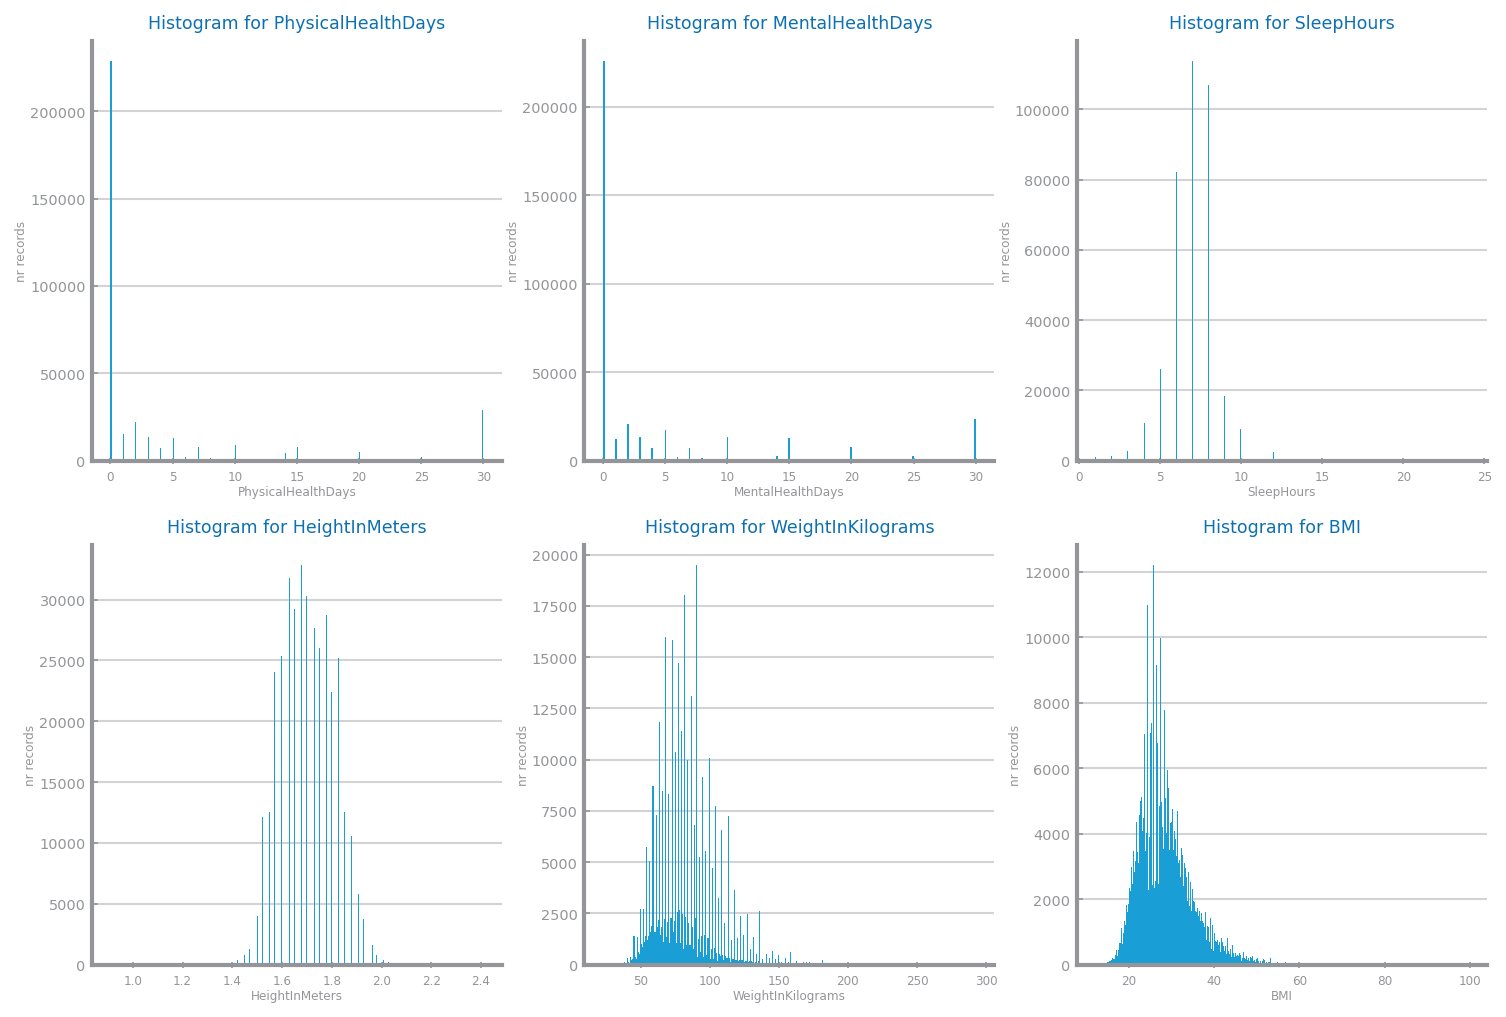

In [18]:
if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"Histogram for {numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(data[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_histograms_numeric.png", bbox_inches="tight")
    show()
else:
    print("There are no numeric variables.")

histogram_with_distributions for PhysicalHealthDays
Gaussian
Exponential
LogNorm
histogram_with_distributions for MentalHealthDays
Gaussian
Exponential
LogNorm
histogram_with_distributions for SleepHours
Gaussian
Exponential
LogNorm
histogram_with_distributions for HeightInMeters
Gaussian
Exponential
LogNorm
histogram_with_distributions for WeightInKilograms
Gaussian
Exponential
LogNorm
histogram_with_distributions for BMI
Gaussian
Exponential
LogNorm


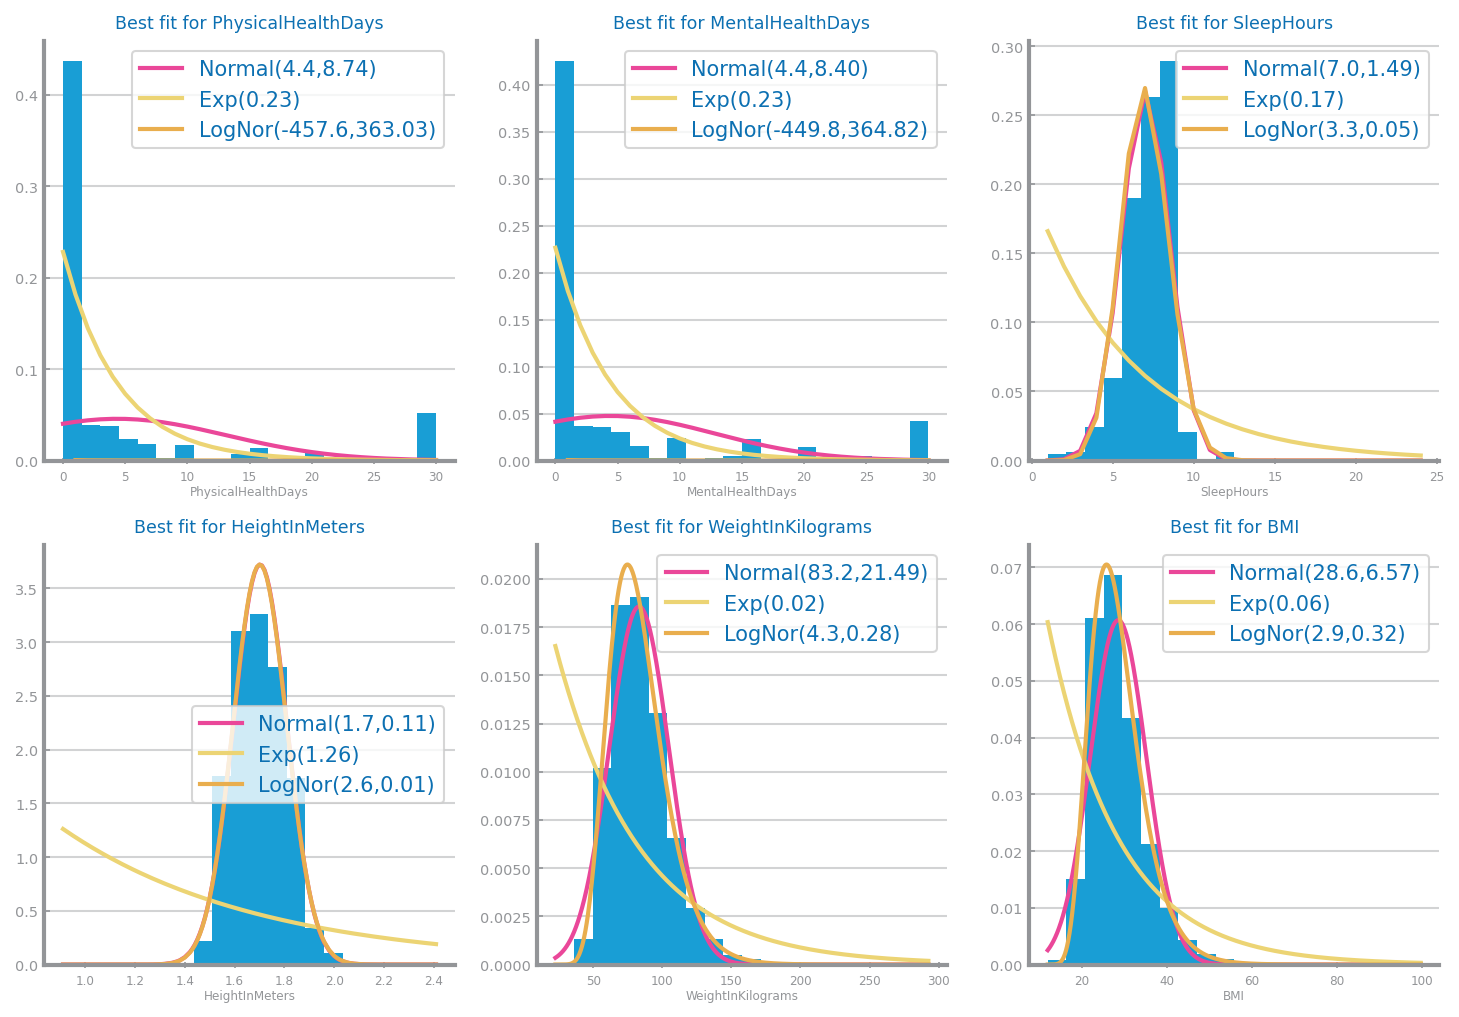

In [19]:
def compute_known_distributions(x_values: list) -> dict:
    distributions = dict()
    # Gaussian
    mean, sigma = norm.fit(x_values)
    distributions["Normal(%.1f,%.2f)" % (mean, sigma)] = norm.pdf(x_values, mean, sigma)
    print("Gaussian")
    # Exponential
    loc, scale = expon.fit(x_values)
    distributions["Exp(%.2f)" % (1 / scale)] = expon.pdf(x_values, loc, scale)
    print("Exponential")
    # LogNorm
    sigma, loc, scale = lognorm.fit(x_values)
    distributions["LogNor(%.1f,%.2f)" % (log(scale), sigma)] = lognorm.pdf(
        x_values, sigma, loc, scale
    )
    print("LogNorm")

    return distributions


def histogram_with_distributions(ax: Axes, series: Series, var: str):
    values: list = series.sort_values().to_list()
    print("histogram_with_distributions for " + var)
    ax.hist(values, 20, density=True)
    distributions: dict = compute_known_distributions(values)
    plot_multiline_chart(
        values,
        distributions,
        ax=ax,
        title="Best fit for %s" % var,
        xlabel=var,
        ylabel="",
    )


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        histogram_with_distributions(axs[i, j], data[numeric[n]].dropna(), numeric[n])
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_histogram_numeric_distribution.png", bbox_inches="tight")
    show()
else:
    print("There are no numeric variables.")

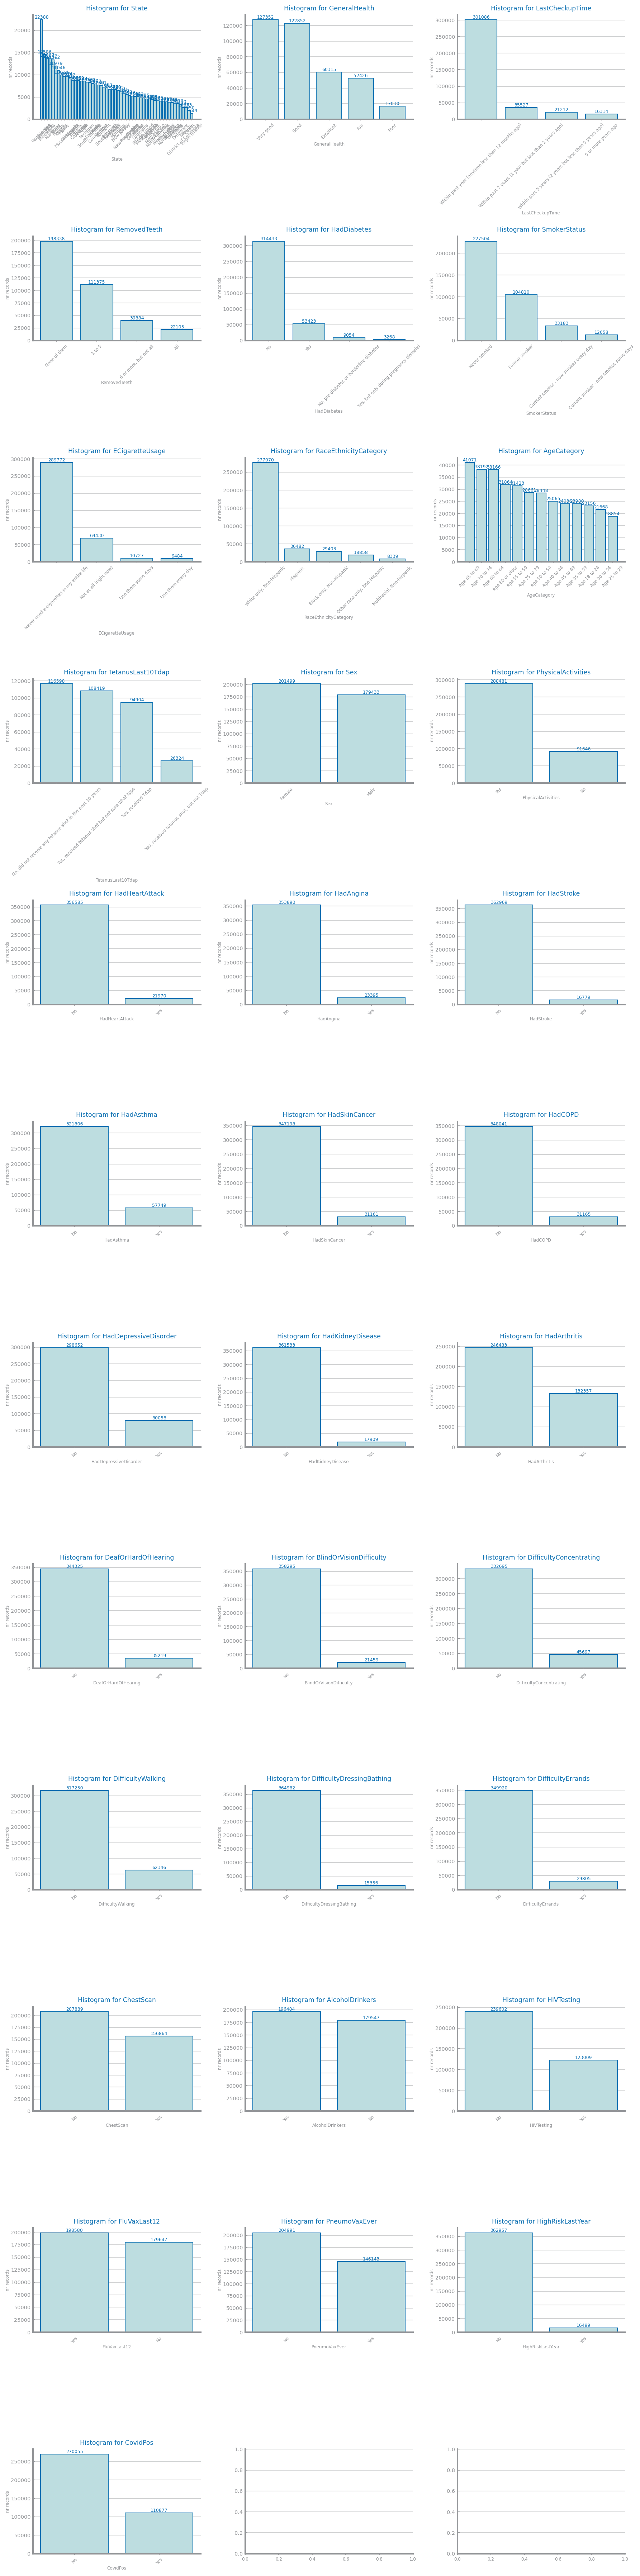

In [25]:
symbolic: list[str] = variables_types["symbolic"] + variables_types["binary"]
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(symbolic)):
        counts: Series = data[symbolic[n]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[i, j],
            title="Histogram for %s" % symbolic[n],
            xlabel=symbolic[n],
            ylabel="nr records",
            percentage=False,
        )
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
        tight_layout()
    savefig(f"images/{file_tag}_histograms_symbolic.png", bbox_inches="tight")
    show()
else:
    print("There are no symbolic variables.")

CovidPos
No     270055
Yes    110877
Name: count, dtype: int64


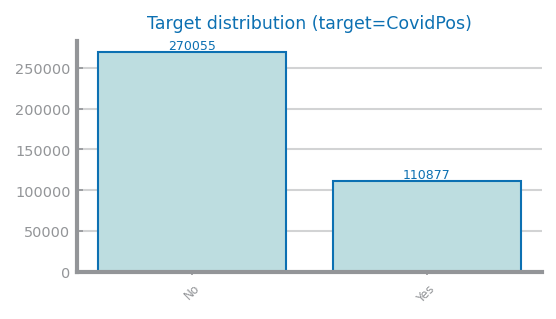

In [21]:
target = "CovidPos"

values: Series = data[target].value_counts()
print(values)

figure(figsize=(4, 2))
plot_bar_chart(
    values.index.to_list(),
    values.to_list(),
    title=f"Target distribution (target={target})",
)
savefig(f"images/{file_tag}_class_distribution.png", bbox_inches="tight")
show()